> **МФИН211 Литвинов А. А.**

# Задание 2. Расчет показателя VAR и реализация процедуры бэк-тестинга 

**Цель задания:**
1. Провести статистический анализ финансового актива и сделать выводы о его распределении
2. Рассчитать показатели VAR и ES историческим и параметрическим методами 
3. Провести процедуру бэк-тестинга показателя VAR
4. Рассчитать показатель портфельного VAR
Для выполнения данного задания целесообразно ознакомиться с материалом, содержащимся в файле "Var_methods.pdf"

## 1.Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
#from __future__ import division

In [3]:
from functools import reduce

In [4]:
from os import listdir

In [5]:
from os.path import isfile,join # функции, необходимые для работы с файлами и директориями

In [6]:
import matplotlib.pyplot as plt # графическая библиотека
%matplotlib inline 

In [7]:
import seaborn as sns # графическая библиотека

## 2.Загрузка данных и их преобразование в необходимый формат

In [8]:
Tickers=['AAPL','JNJ','BAC','NKE']# выбранные для анализа активы

In [14]:
%%bash
pip install wget

wget -nc https://github.com/qununc/UFR/raw/main/no3_var_backtests/AAPL.csv
wget -nc https://github.com/qununc/UFR/raw/main/no3_var_backtests/BAC.csv
wget -nc https://github.com/qununc/UFR/raw/main/no3_var_backtests/JNJ.csv
wget -nc  https://github.com/qununc/UFR/raw/main/no3_var_backtests/NKE.csv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


File ‘AAPL.csv’ already there; not retrieving.

File ‘BAC.csv’ already there; not retrieving.

File ‘JNJ.csv’ already there; not retrieving.

File ‘NKE.csv’ already there; not retrieving.



In [19]:
!ls

/content


In [37]:
import os
path=os.getcwd()
files=[f for f in listdir(path) if (isfile(join(path,f))&(f.endswith('csv')))] 
# создание списка имен файлов 

In [27]:
# создание массива, содержащего даты и цены закрытия для каждого актива
df_list=[]
for f in files:
    fname=join(path,f)
    print (fname)
    df=pd.read_csv(fname,usecols=['Date','Close'],parse_dates=['Date'])
    new_col_name=f[0:(len(f)-4)]
    df.rename(columns={'Close':new_col_name},inplace=True)
    df_list.append(df)

/content/JNJ.csv
/content/AAPL.csv
/content/BAC.csv
/content/NKE.csv


In [28]:
port=reduce(lambda left,right: pd.merge(left,right,on=['Date']),df_list)
# объединение активов в один массив (dataframe)

In [29]:
port.tail()

,Date,JNJ,AAPL,BAC,NKE
1227,2019-01-02,127.750000,157.919998,24.959999,74.059998
1228,2019-01-03,125.720001,142.190002,24.559999,72.750000
1229,2019-01-04,127.830002,148.259995,25.580000,74.650002
1230,2019-01-07,127.010002,147.929993,25.559999,75.720001
1231,2019-01-08,129.960007,150.750000,25.510000,76.730003


In [30]:
port_log=port.iloc[:,1:]

In [31]:
port_log=port_log.apply(lambda x:np.log(x)-np.log(x).shift(1))
### расчет логарифмической доходности для каждого актива

In [32]:
port_log=port_log.iloc[1:,:]

In [33]:
port_log.tail()

,JNJ,AAPL,BAC,NKE
1227,-0.010125,0.001140,0.012903,-0.001080
1228,-0.016018,-0.104924,-0.016155,-0.017847
1229,0.016644,0.041803,0.040692,0.025782
1230,-0.006435,-0.002228,-0.000782,0.014232
1231,0.022961,0.018884,-0.001958,0.013250


In [38]:
port_log.shape

(1231, 4)

Для дальнейшего анализа выберем акции компании Apple(первые 500 торговых дней)

In [39]:
data=port_log['AAPL'][:500]

## 3.Анализ распредления доходности финансового актива

In [40]:
data.describe() # описательная статистика

count    500.000000
mean       0.000367
std        0.015693
min       -0.067965
25%       -0.007355
50%       -0.000029
75%        0.009505
max        0.078794
Name: AAPL, dtype: float64

In [41]:
stats.skew(data)# коэффициент асимметрии

-9.896264789530972e-06

In [42]:
stats.kurtosis(data)# эксцесс

2.9092935773171886

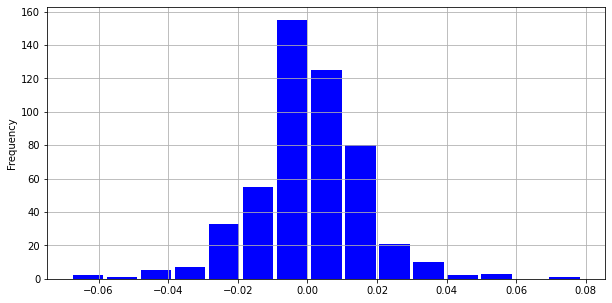

In [43]:
data.plot(kind='hist',grid=True, bins=15, rwidth=0.9,
                   color='blue',figsize=(10,5))

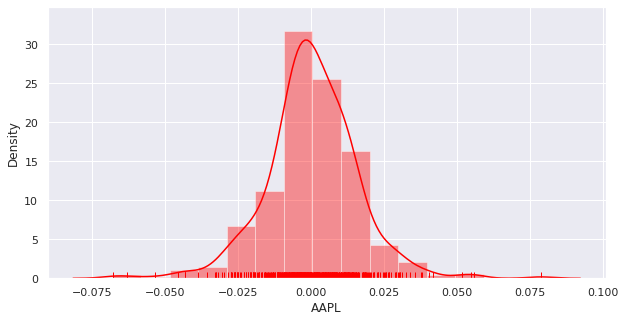

In [46]:
sns.set(rc={'figure.figsize':(10,5)})
sns.distplot(data,bins=15,rug=True,color='red');

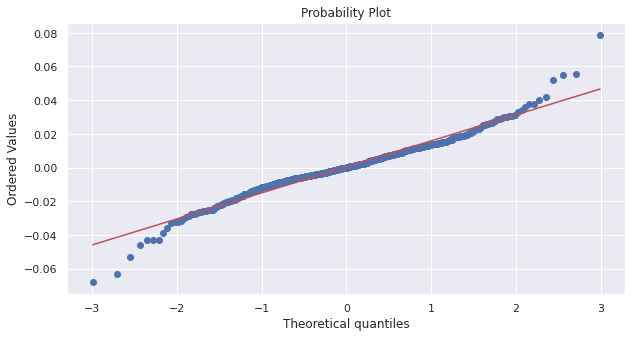

In [47]:
fig = plt.figure(figsize=(10,5))
stats.probplot(data, dist="norm",plot=plt)
plt.show()

In [48]:
stats.normaltest(data)# тест Д'Агостино (основан на значениях эксцесса и ассиметрии )

NormaltestResult(statistic=39.2146399002028, pvalue=3.052454090263835e-09)

> **Основные выводы:** Значение теста говорит о том, что  распределение анализируемого актива отличается от нормального закона. При этом отметим, что гистограмма распределения визуально достаточно близка к нормальному закону.



## 4.Функции для расчета VAR 

Исторический VAR

In [49]:
def VAR_hist(data,alpha=0.05):
    return (np.percentile(data,alpha*100))

Параметрический нормальный VAR

$VAR=\mu+z_\alpha\sigma$

In [50]:
def VAR_normal(data,alpha=0.05,t=1):
    return np.mean(data)*t+stats.norm.ppf(alpha)*np.std(data)*t**.5               

Параметрический нормальный модифицированный VAR

Расчет скорректированного значения $z_\alpha$

 $z_\alpha(corrected)=z_\alpha+\frac{1}{6}\left({z_\alpha}^2-1\right)S+\frac{1}{24}\left({z_\alpha}^3-3z_\alpha\right)K-\frac{1}{36}\left({2z_\alpha}^3-5z_\alpha\right)S^2$

In [51]:
def z_corrected(data,alpha=0.05,t=1):
    return (stats.norm.ppf(alpha)+1/6*(stats.norm.ppf(alpha)**2-1)*(1/t**.5)*stats.skew(data)
                             +1/24*(stats.norm.ppf(alpha)**3-3*stats.norm.ppf(alpha))*(1/t)*stats.kurtosis(data)
                                    -1/36*(2*stats.norm.ppf(alpha)**3-5*stats.norm.ppf(alpha))*(1/t)*
                                    stats.skew(data)**2)

In [52]:
def VAR_normal_modified(data,alpha=0.05,t=1):
    return np.mean(data)*t+z_corrected(data,alpha,t)*np.std(data)*t**.5  

Student VAR

$VAR=\mu+\sqrt{\frac{\nu-2}{\nu}}\sigma t_{\alpha,\nu}$

### Подбор параметров t-распределения 

In [53]:
df=stats.t.fit(port_log['AAPL'])[0]
df

3.1373327820976167

Подбор параметров распределения необходим прежде всего для нахождения числа степеней свободы (первое число в скобках)

In [54]:
def VAR_t(data,alpha=0.05,t=1):
    df=stats.t.fit(data)[0]
    return data.mean()*t+stats.t.ppf(alpha,df)*(((df-2)/df)*t)**.5*np.std(data) 

## 4.Расчет VAR 

$\alpha=0.05$

In [55]:
pd.DataFrame([['Historical',VAR_hist(data),'-'],['Normal',VAR_normal(data),VAR_normal(data,t=10)],
                   ['Normal_modified',VAR_normal_modified(data),VAR_normal_modified(data,t=10)],
                   ['Student',VAR_t(data),VAR_t(data,t=10)]],columns=['Method','1day','10days'])

,Method,1day,10days
0,Historical,-0.025405,-
1,Normal,-0.025420,-0.077878
2,Normal_modified,-0.024500,-0.077587
3,Student,-0.023404,-0.071501


Пример интерпретации VAR (нормальный VAR): c вероятностью 5% однодневные убытки составят 2.5% и более от величины позиции

$\alpha=0.01$

In [56]:
pd.DataFrame([['Historical',VAR_hist(data,alpha=.01),'-'],['Normal',VAR_normal(data,alpha=.01),VAR_normal(data,alpha=.01,t=10)],
                   ['Normal_modified',VAR_normal_modified(data,alpha=.01),VAR_normal_modified(data,alpha=.01,t=10)],
                   ['Student',VAR_t(data,alpha=.01),VAR_t(data,t=10,alpha=.01)]],columns=['Method','1day','10days'])

,Method,1day,10days
0,Historical,-0.043125,-
1,Normal,-0.036104,-0.111664
2,Normal_modified,-0.046768,-0.115036
3,Student,-0.041103,-0.127472


## 5.Реализация процедуры бэк-тестинга VAR 

Процедура бэк-тестинга реализуется посредством скользящего окна. Это значит, что VAR пересчитывается каждый день на основе выборки, равной величине окна. Текущее значение доходности сравнивается с предыдущим значением VAR. В случае, если значение доходности падает ниже значения VAR, число превышений (по модулю) увеличивается на единицу. Далее с помощью статистических тестов проверяется гипотеза о том, в какой степени используемый метод расчета VAR адекватен рассматриваемому процессу. Для проверки гипотезы используется $\chi^2$ - распределения.

**Тест Купиеца**

$LR_{uc}=-2ln[\left(1-p\right)^{T-N}p^N]+2ln{[1-(N/T)]^{T-N}(N/T)^N}$

In [66]:
def LR_uc(T,N,alpha):
    return (-2*np.log((1-alpha)**(T-N)*alpha**N)+2*np.log((1-N/T)**(T-N)*(N/T)**(N)))

Тест Кристоферссона

$LR_{ind}=-2ln[(1-\pi)^{\left(T_{00}+T_{10}\right)}\pi^{\left(T_{01}+T_{11}\right)}]+2ln[(1-π_0)^{T_{00}}π_0^{T_{01}}(1-π_1)^{T_{10}}π_1^{T_{11}}]$

In [57]:
def LR_ind(exceed):
    T_11=0
    T_10=0
    T_00=0
    T_01=0
    for i in range(1,len(exceed)):
        #print(exceed[i-1],exceed[i])
        if ((exceed[i-1]==True)&(exceed[i]==True)):
            T_11+=1
        elif((exceed[i-1]==True)&(exceed[i]==False)):
            T_10+=1
        elif((exceed[i-1]==False)&(exceed[i]==False)):
            T_00+=1
        elif((exceed[i-1]==False)&(exceed[i]==True)):
            T_01+=1
    p_0=T_01/(T_00+T_01)
    p_1=T_11/(T_10+T_11)
    p=(T_01+T_11) /(T_00+T_01+T_10+T_11)
    print(T_11,T_01,T_00,T_10)
    return (-2*np.log((1-p)**(T_00+T_10)*p**(T_01+T_11))+2*np.log((1-p_0)**(T_00)*p_0**T_01*(1-p_1)**(T_10)*p_1**T_11))        

In [58]:
window=250 # установим величину скользящего окна

Процедура бэк-тестинга реализуется сразу для всех рассматриваемых методов. Выполнение процедуры может занять некоторое время.

In [59]:
f_list=[VAR_hist,VAR_normal,VAR_normal_modified,VAR_t]
#  список функций, используемых для рачета VAR

In [60]:
T=len(port_log['AAPL'][window:])

In [61]:
# Критические значение хи-квадрат критерия (уровень значимости - 0.05, ч.с.с.-1)
chi2=stats.chi2.ppf(0.95,1)
chi2

3.841458820694124

### VAR 5%

In [62]:
VAR_5_backtest=[list(port_log['AAPL'].rolling(window).apply(lambda x:f(x),raw=True)[window-1:-1]) for f in f_list]
# расчет VAR методом скользящего окна для каждого метода

In [63]:
List_exceed_5=[list(port_log['AAPL'][window:]<list(l)) for l in VAR_5_backtest]
# проверка превышения (по модулю) доходности значения VAR по каждому торговому дню

In [64]:
Number_exceed_5=[sum(l) for l in List_exceed_5]
# число превышений 

In [67]:
List_LR_uc_5=[LR_uc(T,N,0.05) for N in Number_exceed_5]
# тест Купиеца

In [68]:
List_LR_ind_5=[LR_ind(l) for l in List_exceed_5]
# тест Кристоферссона

10 59 852 59
10 54 862 54
11 60 849 60
12 64 840 64


In [69]:
0.05*len(port_log['AAPL'][window:])
# число превышений исходя из значения $\alpha$

49.050000000000004

In [70]:
Method=['Historical','Normal','Normal_modified','Student']

In [71]:
pd.DataFrame({'Method':Method,'N_exceed':Number_exceed_5,'LR_uc':List_LR_uc_5,'Pass_LR_uc':(List_LR_uc_5<chi2),'LR_ind':List_LR_ind_5
             ,'Pass_LR_ind':(List_LR_ind_5<chi2)},columns=['Method','N_exceed','LR_uc','Pass_LR_uc','LR_ind','Pass_LR_ind'])

,Method,N_exceed,LR_uc,Pass_LR_uc,LR_ind,Pass_LR_ind
0,Historical,69,7.624897,False,5.033308,False
1,Normal,64,4.394606,False,7.017353,False
2,Normal_modified,71,9.138327,False,6.124082,False
3,Student,76,13.446719,False,5.992145,False


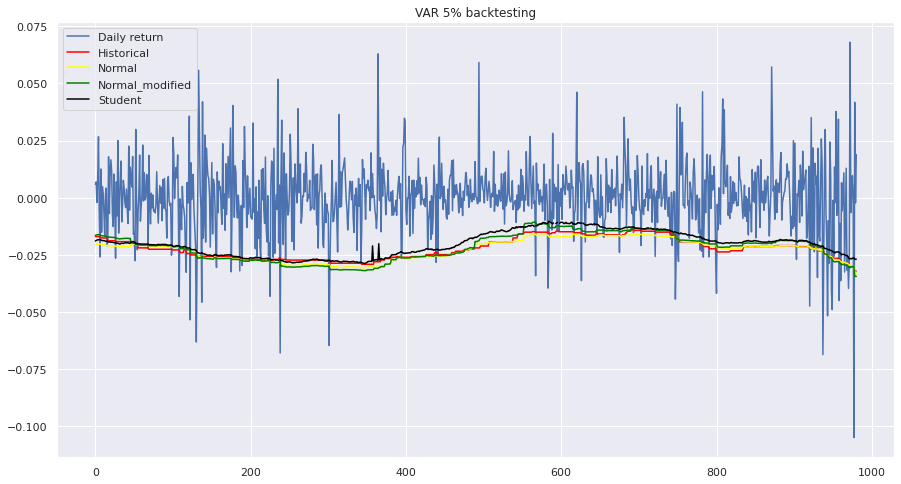

In [72]:
plt.figure(figsize=(15,8))
plt.plot(list(port_log['AAPL'][window:]),label='Daily return')
colors=['red','yellow','green','black']
methods=['']
for i in range(0,4):
    plt.plot(VAR_5_backtest[i],color=colors[i],label=Method[i])
    plt.title('VAR 5% backtesting')
    plt.legend()

**Выводы:** Ни один метод расчета VAR не прошел тест Купиеца. Тест на независмость превышений (тест Кристоферссона) не прошел ни один метод.

### VAR 1%

In [73]:
VAR_1_backtest=[list(port_log['AAPL'].rolling(window).apply(lambda x:f(x,alpha=0.01),raw=True)[window-1:-1]) for f in f_list]

In [74]:
List_exceed_1=[list(port_log['AAPL'][window:]<list(l)) for l in VAR_1_backtest]

In [75]:
Number_exceed_1=[sum(l) for l in List_exceed_1]

In [76]:
List_LR_uc_1=[LR_uc(T,N,0.01) for N in Number_exceed_1]

In [77]:
List_LR_ind_1=[LR_ind(l) for l in List_exceed_1 ]

0 16 948 16
2 22 934 22
0 16 948 16
1 17 945 17


In [78]:
0.01*len(port_log['AAPL'][window:])
# число превышений исходя из значения $\alpha$

9.81

In [79]:
pd.DataFrame({'Method':Method,'N_exceed':Number_exceed_1,'LR_uc':List_LR_uc_1,'Pass_LR_uc':(List_LR_uc_1<chi2),'LR_ind':List_LR_ind_1
             ,'Pass_LR_ind':(List_LR_ind_1<chi2)},columns=['Method','N_exceed','LR_uc','Pass_LR_uc','LR_ind','Pass_LR_ind'])

,Method,N_exceed,LR_uc,Pass_LR_uc,LR_ind,Pass_LR_ind
0,Historical,16,3.313503,True,0.531145,True
1,Normal,24,14.771621,False,2.249924,True
2,Normal_modified,16,3.313503,True,0.531145,True
3,Student,18,5.540162,False,0.926688,True


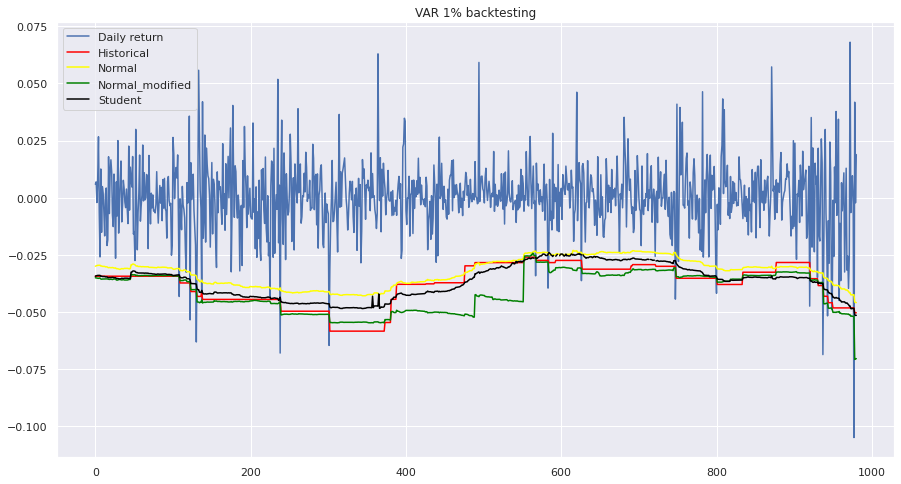

In [80]:
plt.figure(figsize=(15,8))
plt.plot(list(port_log['AAPL'][window:]),label='Daily return')
colors=['red','yellow','green','black']
methods=['']
for i in range(0,4):
    plt.plot(VAR_1_backtest[i],color=colors[i],label=Method[i])
    plt.title('VAR 1% backtesting')
    plt.legend()

**Выводы:** Исторический,  модифицированный  методы расчета VAR прошли тест Купиеца. Тест на независмость превышений (тест Кристоферссона)  прошли все методы. Необходимо обратить внимание на то, что чем дальше мы "продвигаемся" по левому хвосту рапсределения, тем менее точным становится оценка VAR на основе нормального распределения.

### VAR 0.1%

In [81]:
VAR_01_backtest=[list(port_log['AAPL'].rolling(window).apply(lambda x:f(x,alpha=0.001),raw=True)[window-1:-1]) for f in f_list]

In [82]:
List_exceed_01=[list(port_log['AAPL'][window:]<list(l)) for l in VAR_01_backtest]

In [83]:
Number_exceed_01=[sum(l) for l in List_exceed_01]

In [84]:
List_LR_uc_01=[LR_uc(T,N,0.001) for N in Number_exceed_01]

In [85]:
List_LR_ind_01=[LR_ind(l) for l in List_exceed_1 ]

0 16 948 16
2 22 934 22
0 16 948 16
1 17 945 17


In [86]:
pd.DataFrame({'Method':Method,'N_exceed':Number_exceed_01,'LR_uc':List_LR_uc_01,'Pass_LR_uc':(List_LR_uc_01<chi2),'LR_ind':List_LR_ind_01
             ,'Pass_LR_ind':(List_LR_ind_01<chi2)},columns=['Method','N_exceed','LR_uc','Pass_LR_uc','LR_ind','Pass_LR_ind'])

,Method,N_exceed,LR_uc,Pass_LR_uc,LR_ind,Pass_LR_ind
0,Historical,10,28.480615,False,0.531145,True
1,Normal,14,48.566445,False,2.249924,True
2,Normal_modified,2,0.812380,True,0.531145,True
3,Student,2,0.812380,True,0.926688,True


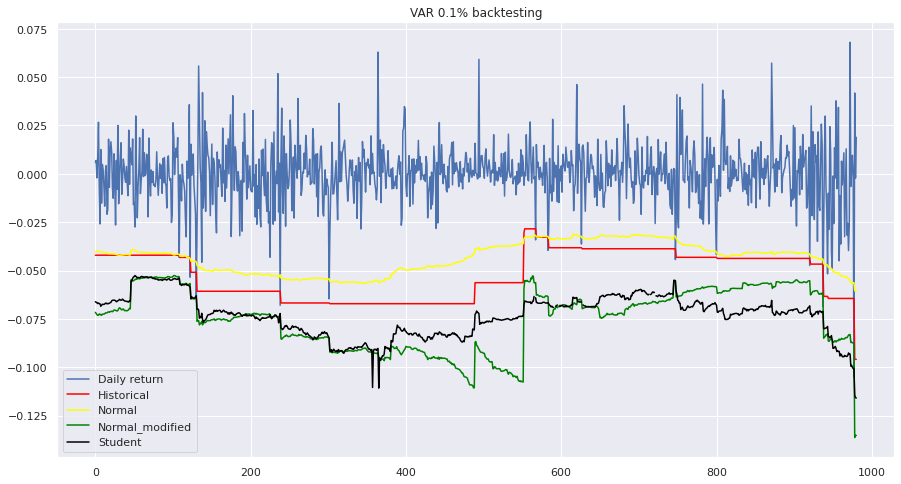

In [87]:
plt.figure(figsize=(15,8))
plt.plot(list(port_log['AAPL'][window:]),label='Daily return')
colors=['red','yellow','green','black']
methods=['']
for i in range(0,4):
    plt.plot(VAR_01_backtest[i],color=colors[i],label=Method[i])
    plt.title('VAR 0.1% backtesting')
    plt.legend()

**Выводы:** Модифицированный, t-распределение методы расчета VAR прошли тест Купиеца. Тест на независмость превышений (тест Кристоферссона)  прошли все методы. Необходимо обратить внимание на то, что чем дальше мы "продвигаемся" по левому хвосту рапсределения, тем менее точным становится оценка VAR на основе нормального распределения.

## 6.Расчет Expected shortfall

$\alpha=0.05$

In [88]:
var=VAR_hist(data)

In [89]:
# исторический ES
ES_hist_05=np.mean(data[data<var])
ES_hist_05

-0.035735427470334535

In [90]:
alpha=0.05

Для вычисления параметрического ES используются параметры выбрнного распределения. Ниже приведена формула ES для нормального распределения.

$ES=-\sigma\frac{exp\left(-\frac{z_\alpha^2}{2}\right)}{\alpha\sqrt{2\pi}}$

In [91]:
z_alpha=stats.norm.ppf(alpha)# процентная точка нормального распределения

In [92]:
# параметрический VAR
ES_norm_05=-np.std(data)*(np.exp(-(z_alpha**2/2)))/(alpha*np.sqrt(2*np.pi))
ES_norm_05

-0.03233807193390692

$\alpha=0.01$

In [93]:
var=VAR_hist(data,.01)

In [94]:
# исторический ES
ES_hist_01=np.mean(data[data<var])
ES_hist_01

-0.054692061996719235

In [95]:
alpha=0.01

In [96]:
z_alpha=stats.norm.ppf(alpha)

In [97]:
# параметрический VAR
ES_norm_01=-np.std(data)*(np.exp(-(z_alpha**2/2)))/(alpha*np.sqrt(2*np.pi))
ES_norm_01

-0.04178375625687006

## Портфельный VAR

Парметрический портфельный VAR рассчитывается на основе ковариационной матрицы

$VAR=\sqrt{\omega^{'}\Sigma\omega}z_\alpha$

In [98]:
mean=port_log.mean(axis=0)

In [99]:
mean

JNJ     0.000279
AAPL    0.000535
BAC     0.000355
NKE     0.000579
dtype: float64

In [100]:
np.corrcoef(port_log,rowvar=False)
# корреляционая матрица (приводится справочно)

array([[1.        , 0.31827607, 0.32707997, 0.31228355],
       [0.31827607, 1.        , 0.37378076, 0.33596604],
       [0.32707997, 0.37378076, 1.        , 0.36572264],
       [0.31228355, 0.33596604, 0.36572264, 1.        ]])

In [101]:
weights=np.repeat(0.25,4)
# вектор весов активов, находящихся в портфеле

In [102]:
Sigma_port=np.sqrt(np.dot(np.dot(weights.T,np.cov(port_log,rowvar=False)),weights.T))
Sigma_port
# стандартное отклонение портфеля

0.01008750954006348

In [103]:
Sigma_port*stats.norm.ppf(0.01)

-0.023467056372893376

In [104]:
sum(mean*weights)

0.00043728883550038755

In [105]:
VAR_port=sum(mean*weights)+Sigma_port*stats.norm.ppf(0.01)
VAR_port
# дневной портфельный VAR для уровня 1%

-0.023029767537392987

# Задание

Пункты 2-5 Задания необходимо выполнить для не менее двух активов
1. Выбрать любой внешний источник финансовой информации(Yahoo, FRED, Quandle и т.д.) и выгрузить динамику любых актива (не менее четырех активов, период - не менее 1000 торгвых дней)
2. Провести статистический анализ актива и провеить гипотезу нормальности распределения
3. Рассчитать исторический и параметрический VAR для периода 1 и 10 дней для уровней 5% и 1%
4. Провести процедуру бэк-тестинга для однодневного VAR
5. Рассчитать показатель ES 
6. Рассчитать портфельный VAR 
7. Сделать выводы

## 2.Загрузка данных и их преобразование в необходимый формат
Выбрать любой внешний источник финансовой информации(Yahoo, FRED, Quandle и т.д.) и выгрузить динамику любых актива (не менее четырех активов, период - не менее 1000 торгвых дней)

In [12]:
!pip install yfinance

In [17]:
import datetime
import yfinance as yf
from tqdm import tqdm

In [31]:
Tickers=['MSFT','AMZN','AMD','NVDA']# выбранные для анализа активы

In [36]:
# Input Start and End Date
start = datetime.datetime(2008,1,1)
end = datetime.datetime(2022,5,1)

# create empty dataframe
stock_final = pd.DataFrame()

# iterate over each symbol
for i in tqdm(Tickers):  
    
    # print the symbol which is being downloaded
    # print( str(Symbols.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
    
    try:
        # download the stock price 
        stock = []
        stock = yf.download(i,start=start, end=end, progress=False, show_errors=False).loc[:, ['Adj Close', 'Volume']]
        
        # append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            stock['Name']=i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None

stock_result = stock_final.drop(['Volume'], axis=1).reset_index()
stock_result.rename({'Adj Close' : 'adj_close'}, axis=1, inplace=True)
stock_result['Date'] = pd.to_datetime(stock_result['Date'], infer_datetime_format=True)
stock_result = stock_result.drop_duplicates(ignore_index=True)
stocks_pivoted = stock_result.pivot_table(
    index='Name', columns='Date', values='adj_close', aggfunc='mean'
).T

100%|██████████| 4/4 [00:01<00:00,  2.99it/s]


In [35]:
stocks_pivoted.isna().sum()

Name
AMD     0
AMZN    0
MSFT    0
NVDA    0
dtype: int64

In [33]:
stocks_pivoted.head()

Name,AMD,AMZN,MSFT,NVDA
Date,,,,
2008-01-02,7.14,4.8125,25.983715,7.577939
2008-01-03,6.77,4.7605,26.094379,7.518253
2008-01-04,6.25,4.4395,25.364004,6.886950
2008-01-07,6.08,4.4410,25.533686,6.175296
2008-01-08,6.00,4.3940,24.677898,6.306149


In [26]:
port_log=stocks_pivoted.apply(lambda x:np.log(x)-np.log(x).shift(1))
### расчет логарифмической доходности для каждого актива

In [ ]:
port_log=port_log.iloc[1:,:]

In [27]:
port_log.tail()

Name,AAPL,BAC,JNJ,NKE
Date,,,,
2022-04-25,0.006715,-0.007215,0.024324,-0.008794
2022-04-26,-0.038043,-0.022784,-0.007176,-0.059746
2022-04-27,-0.001468,-0.005502,-0.014069,0.005956
2022-04-28,0.044166,0.015330,0.007441,0.046809
2022-04-29,-0.037292,-0.031179,-0.016488,-0.018670


In [28]:
port_log.shape

(3608, 4)

Для дальнейшего анализа выберем акции компании Apple(первые 500 торговых дней)

In [29]:
data=port_log['AAPL'][:500]

## 3.Анализ распредления доходности финансового актива

In [30]:
data.describe() # описательная статистика

count    499.000000
mean       0.000073
std        0.030469
min       -0.197470
25%       -0.015921
50%        0.001329
75%        0.017154
max        0.130194
Name: AAPL, dtype: float64

In [ ]:
stats.skew(data)# коэффициент асимметрии

-9.896264789530972e-06

In [ ]:
stats.kurtosis(data)# эксцесс

2.9092935773171886

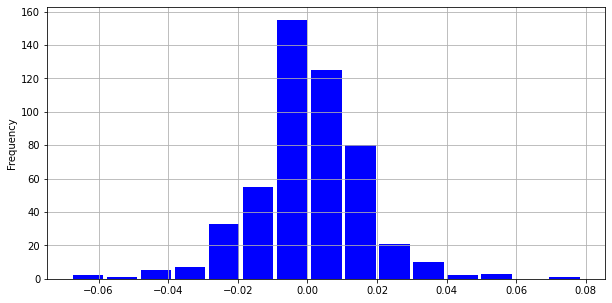

In [ ]:
data.plot(kind='hist',grid=True, bins=15, rwidth=0.9,
                   color='blue',figsize=(10,5))

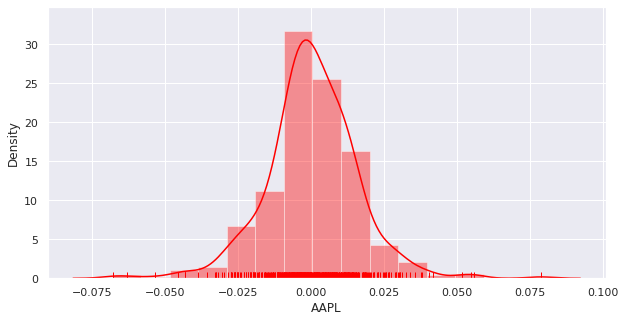

In [ ]:
sns.set(rc={'figure.figsize':(10,5)})
sns.distplot(data,bins=15,rug=True,color='red');

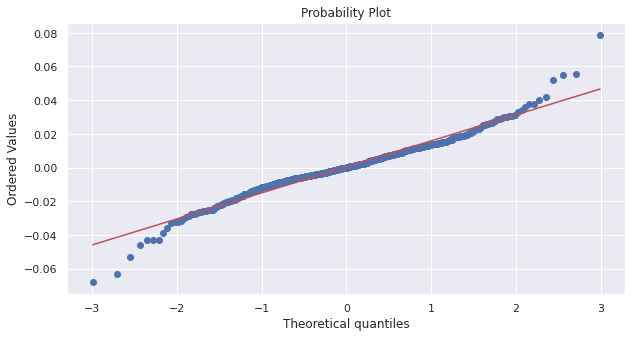

In [ ]:
fig = plt.figure(figsize=(10,5))
stats.probplot(data, dist="norm",plot=plt)
plt.show()

In [ ]:
stats.normaltest(data)# тест Д'Агостино (основан на значениях эксцесса и ассиметрии )

NormaltestResult(statistic=39.2146399002028, pvalue=3.052454090263835e-09)

> **Основные выводы:** Значение теста говорит о том, что  распределение анализируемого актива отличается от нормального закона. При этом отметим, что гистограмма распределения визуально достаточно близка к нормальному закону.



## 4.Функции для расчета VAR 

Исторический VAR

In [ ]:
def VAR_hist(data,alpha=0.05):
    return (np.percentile(data,alpha*100))

Параметрический нормальный VAR

$VAR=\mu+z_\alpha\sigma$

In [ ]:
def VAR_normal(data,alpha=0.05,t=1):
    return np.mean(data)*t+stats.norm.ppf(alpha)*np.std(data)*t**.5               

Параметрический нормальный модифицированный VAR

Расчет скорректированного значения $z_\alpha$

 $z_\alpha(corrected)=z_\alpha+\frac{1}{6}\left({z_\alpha}^2-1\right)S+\frac{1}{24}\left({z_\alpha}^3-3z_\alpha\right)K-\frac{1}{36}\left({2z_\alpha}^3-5z_\alpha\right)S^2$

In [ ]:
def z_corrected(data,alpha=0.05,t=1):
    return (stats.norm.ppf(alpha)+1/6*(stats.norm.ppf(alpha)**2-1)*(1/t**.5)*stats.skew(data)
                             +1/24*(stats.norm.ppf(alpha)**3-3*stats.norm.ppf(alpha))*(1/t)*stats.kurtosis(data)
                                    -1/36*(2*stats.norm.ppf(alpha)**3-5*stats.norm.ppf(alpha))*(1/t)*
                                    stats.skew(data)**2)

In [ ]:
def VAR_normal_modified(data,alpha=0.05,t=1):
    return np.mean(data)*t+z_corrected(data,alpha,t)*np.std(data)*t**.5  

Student VAR

$VAR=\mu+\sqrt{\frac{\nu-2}{\nu}}\sigma t_{\alpha,\nu}$

### Подбор параметров t-распределения 

In [ ]:
df=stats.t.fit(port_log['AAPL'])[0]
df

3.1373327820976167

Подбор параметров распределения необходим прежде всего для нахождения числа степеней свободы (первое число в скобках)

In [ ]:
def VAR_t(data,alpha=0.05,t=1):
    df=stats.t.fit(data)[0]
    return data.mean()*t+stats.t.ppf(alpha,df)*(((df-2)/df)*t)**.5*np.std(data) 

## 4.Расчет VAR 

$\alpha=0.05$

In [ ]:
pd.DataFrame([['Historical',VAR_hist(data),'-'],['Normal',VAR_normal(data),VAR_normal(data,t=10)],
                   ['Normal_modified',VAR_normal_modified(data),VAR_normal_modified(data,t=10)],
                   ['Student',VAR_t(data),VAR_t(data,t=10)]],columns=['Method','1day','10days'])

,Method,1day,10days
0,Historical,-0.025405,-
1,Normal,-0.025420,-0.077878
2,Normal_modified,-0.024500,-0.077587
3,Student,-0.023404,-0.071501


Пример интерпретации VAR (нормальный VAR): c вероятностью 5% однодневные убытки составят 2.5% и более от величины позиции

$\alpha=0.01$

In [ ]:
pd.DataFrame([['Historical',VAR_hist(data,alpha=.01),'-'],['Normal',VAR_normal(data,alpha=.01),VAR_normal(data,alpha=.01,t=10)],
                   ['Normal_modified',VAR_normal_modified(data,alpha=.01),VAR_normal_modified(data,alpha=.01,t=10)],
                   ['Student',VAR_t(data,alpha=.01),VAR_t(data,t=10,alpha=.01)]],columns=['Method','1day','10days'])

,Method,1day,10days
0,Historical,-0.043125,-
1,Normal,-0.036104,-0.111664
2,Normal_modified,-0.046768,-0.115036
3,Student,-0.041103,-0.127472


## 5.Реализация процедуры бэк-тестинга VAR 

Процедура бэк-тестинга реализуется посредством скользящего окна. Это значит, что VAR пересчитывается каждый день на основе выборки, равной величине окна. Текущее значение доходности сравнивается с предыдущим значением VAR. В случае, если значение доходности падает ниже значения VAR, число превышений (по модулю) увеличивается на единицу. Далее с помощью статистических тестов проверяется гипотеза о том, в какой степени используемый метод расчета VAR адекватен рассматриваемому процессу. Для проверки гипотезы используется $\chi^2$ - распределения.

**Тест Купиеца**

$LR_{uc}=-2ln[\left(1-p\right)^{T-N}p^N]+2ln{[1-(N/T)]^{T-N}(N/T)^N}$

In [ ]:
def LR_uc(T,N,alpha):
    return (-2*np.log((1-alpha)**(T-N)*alpha**N)+2*np.log((1-N/T)**(T-N)*(N/T)**(N)))

Тест Кристоферссона

$LR_{ind}=-2ln[(1-\pi)^{\left(T_{00}+T_{10}\right)}\pi^{\left(T_{01}+T_{11}\right)}]+2ln[(1-π_0)^{T_{00}}π_0^{T_{01}}(1-π_1)^{T_{10}}π_1^{T_{11}}]$

In [ ]:
def LR_ind(exceed):
    T_11=0
    T_10=0
    T_00=0
    T_01=0
    for i in range(1,len(exceed)):
        #print(exceed[i-1],exceed[i])
        if ((exceed[i-1]==True)&(exceed[i]==True)):
            T_11+=1
        elif((exceed[i-1]==True)&(exceed[i]==False)):
            T_10+=1
        elif((exceed[i-1]==False)&(exceed[i]==False)):
            T_00+=1
        elif((exceed[i-1]==False)&(exceed[i]==True)):
            T_01+=1
    p_0=T_01/(T_00+T_01)
    p_1=T_11/(T_10+T_11)
    p=(T_01+T_11) /(T_00+T_01+T_10+T_11)
    print(T_11,T_01,T_00,T_10)
    return (-2*np.log((1-p)**(T_00+T_10)*p**(T_01+T_11))+2*np.log((1-p_0)**(T_00)*p_0**T_01*(1-p_1)**(T_10)*p_1**T_11))        

In [ ]:
window=250 # установим величину скользящего окна

Процедура бэк-тестинга реализуется сразу для всех рассматриваемых методов. Выполнение процедуры может занять некоторое время.

In [ ]:
f_list=[VAR_hist,VAR_normal,VAR_normal_modified,VAR_t]
#  список функций, используемых для рачета VAR

In [ ]:
T=len(port_log['AAPL'][window:])

In [ ]:
# Критические значение хи-квадрат критерия (уровень значимости - 0.05, ч.с.с.-1)
chi2=stats.chi2.ppf(0.95,1)
chi2

3.841458820694124

### VAR 5%

In [ ]:
VAR_5_backtest=[list(port_log['AAPL'].rolling(window).apply(lambda x:f(x),raw=True)[window-1:-1]) for f in f_list]
# расчет VAR методом скользящего окна для каждого метода

In [ ]:
List_exceed_5=[list(port_log['AAPL'][window:]<list(l)) for l in VAR_5_backtest]
# проверка превышения (по модулю) доходности значения VAR по каждому торговому дню

In [ ]:
Number_exceed_5=[sum(l) for l in List_exceed_5]
# число превышений 

In [ ]:
List_LR_uc_5=[LR_uc(T,N,0.05) for N in Number_exceed_5]
# тест Купиеца

In [ ]:
List_LR_ind_5=[LR_ind(l) for l in List_exceed_5]
# тест Кристоферссона

10 59 852 59
10 54 862 54
11 60 849 60
12 64 840 64


In [ ]:
0.05*len(port_log['AAPL'][window:])
# число превышений исходя из значения $\alpha$

49.050000000000004

In [ ]:
Method=['Historical','Normal','Normal_modified','Student']

In [ ]:
pd.DataFrame({'Method':Method,'N_exceed':Number_exceed_5,'LR_uc':List_LR_uc_5,'Pass_LR_uc':(List_LR_uc_5<chi2),'LR_ind':List_LR_ind_5
             ,'Pass_LR_ind':(List_LR_ind_5<chi2)},columns=['Method','N_exceed','LR_uc','Pass_LR_uc','LR_ind','Pass_LR_ind'])

,Method,N_exceed,LR_uc,Pass_LR_uc,LR_ind,Pass_LR_ind
0,Historical,69,7.624897,False,5.033308,False
1,Normal,64,4.394606,False,7.017353,False
2,Normal_modified,71,9.138327,False,6.124082,False
3,Student,76,13.446719,False,5.992145,False


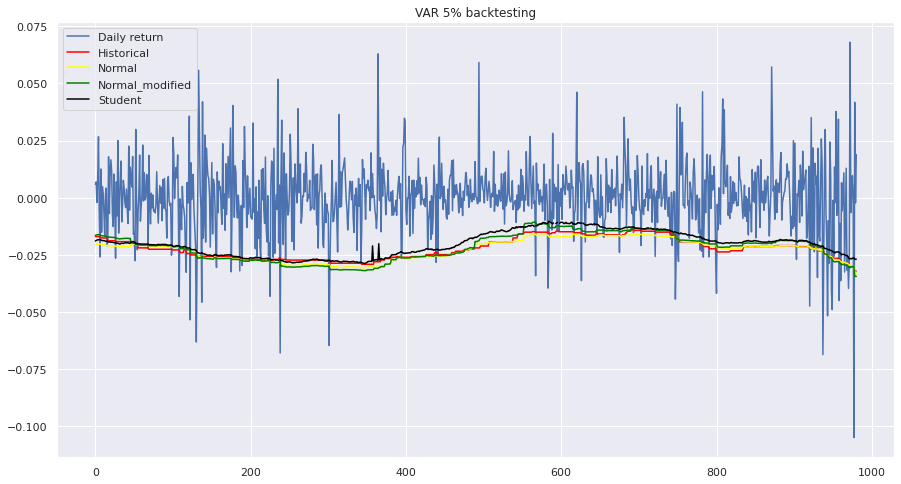

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(list(port_log['AAPL'][window:]),label='Daily return')
colors=['red','yellow','green','black']
methods=['']
for i in range(0,4):
    plt.plot(VAR_5_backtest[i],color=colors[i],label=Method[i])
    plt.title('VAR 5% backtesting')
    plt.legend()

**Выводы:** Ни один метод расчета VAR не прошел тест Купиеца. Тест на независмость превышений (тест Кристоферссона) не прошел ни один метод.

### VAR 1%

In [ ]:
VAR_1_backtest=[list(port_log['AAPL'].rolling(window).apply(lambda x:f(x,alpha=0.01),raw=True)[window-1:-1]) for f in f_list]

In [ ]:
List_exceed_1=[list(port_log['AAPL'][window:]<list(l)) for l in VAR_1_backtest]

In [ ]:
Number_exceed_1=[sum(l) for l in List_exceed_1]

In [ ]:
List_LR_uc_1=[LR_uc(T,N,0.01) for N in Number_exceed_1]

In [ ]:
List_LR_ind_1=[LR_ind(l) for l in List_exceed_1 ]

0 16 948 16
2 22 934 22
0 16 948 16
1 17 945 17


In [ ]:
0.01*len(port_log['AAPL'][window:])
# число превышений исходя из значения $\alpha$

9.81

In [ ]:
pd.DataFrame({'Method':Method,'N_exceed':Number_exceed_1,'LR_uc':List_LR_uc_1,'Pass_LR_uc':(List_LR_uc_1<chi2),'LR_ind':List_LR_ind_1
             ,'Pass_LR_ind':(List_LR_ind_1<chi2)},columns=['Method','N_exceed','LR_uc','Pass_LR_uc','LR_ind','Pass_LR_ind'])

,Method,N_exceed,LR_uc,Pass_LR_uc,LR_ind,Pass_LR_ind
0,Historical,16,3.313503,True,0.531145,True
1,Normal,24,14.771621,False,2.249924,True
2,Normal_modified,16,3.313503,True,0.531145,True
3,Student,18,5.540162,False,0.926688,True


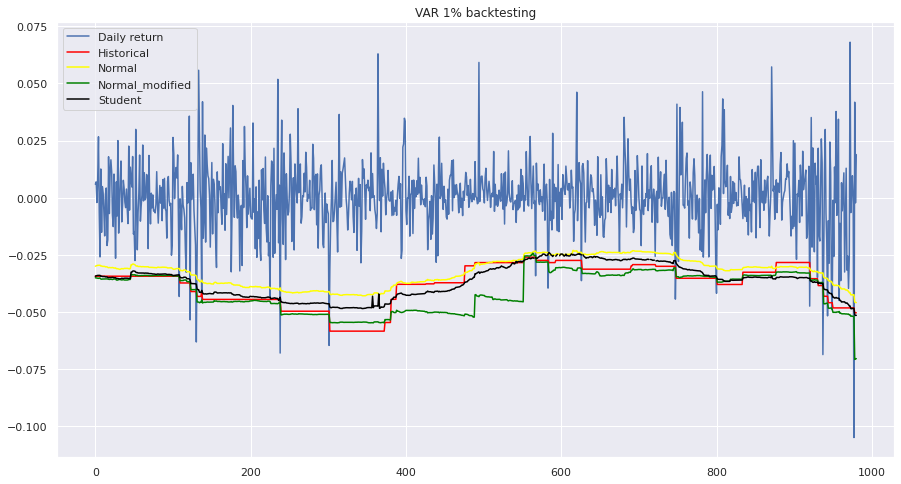

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(list(port_log['AAPL'][window:]),label='Daily return')
colors=['red','yellow','green','black']
methods=['']
for i in range(0,4):
    plt.plot(VAR_1_backtest[i],color=colors[i],label=Method[i])
    plt.title('VAR 1% backtesting')
    plt.legend()

**Выводы:** Исторический,  модифицированный  методы расчета VAR прошли тест Купиеца. Тест на независмость превышений (тест Кристоферссона)  прошли все методы. Необходимо обратить внимание на то, что чем дальше мы "продвигаемся" по левому хвосту рапсределения, тем менее точным становится оценка VAR на основе нормального распределения.

### VAR 0.1%

In [ ]:
VAR_01_backtest=[list(port_log['AAPL'].rolling(window).apply(lambda x:f(x,alpha=0.001),raw=True)[window-1:-1]) for f in f_list]

In [ ]:
List_exceed_01=[list(port_log['AAPL'][window:]<list(l)) for l in VAR_01_backtest]

In [ ]:
Number_exceed_01=[sum(l) for l in List_exceed_01]

In [ ]:
List_LR_uc_01=[LR_uc(T,N,0.001) for N in Number_exceed_01]

In [ ]:
List_LR_ind_01=[LR_ind(l) for l in List_exceed_1 ]

0 16 948 16
2 22 934 22
0 16 948 16
1 17 945 17


In [ ]:
pd.DataFrame({'Method':Method,'N_exceed':Number_exceed_01,'LR_uc':List_LR_uc_01,'Pass_LR_uc':(List_LR_uc_01<chi2),'LR_ind':List_LR_ind_01
             ,'Pass_LR_ind':(List_LR_ind_01<chi2)},columns=['Method','N_exceed','LR_uc','Pass_LR_uc','LR_ind','Pass_LR_ind'])

,Method,N_exceed,LR_uc,Pass_LR_uc,LR_ind,Pass_LR_ind
0,Historical,10,28.480615,False,0.531145,True
1,Normal,14,48.566445,False,2.249924,True
2,Normal_modified,2,0.812380,True,0.531145,True
3,Student,2,0.812380,True,0.926688,True


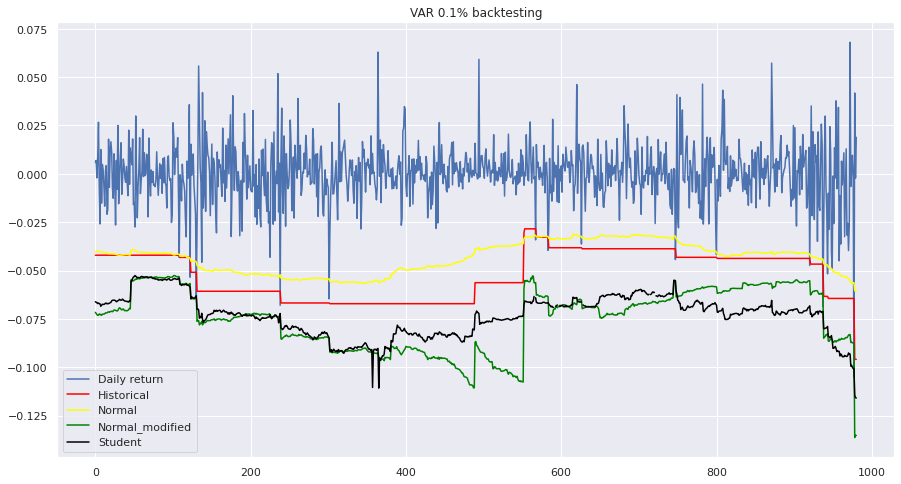

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(list(port_log['AAPL'][window:]),label='Daily return')
colors=['red','yellow','green','black']
methods=['']
for i in range(0,4):
    plt.plot(VAR_01_backtest[i],color=colors[i],label=Method[i])
    plt.title('VAR 0.1% backtesting')
    plt.legend()

**Выводы:** Модифицированный, t-распределение методы расчета VAR прошли тест Купиеца. Тест на независмость превышений (тест Кристоферссона)  прошли все методы. Необходимо обратить внимание на то, что чем дальше мы "продвигаемся" по левому хвосту рапсределения, тем менее точным становится оценка VAR на основе нормального распределения.

## 6.Расчет Expected shortfall

$\alpha=0.05$

In [ ]:
var=VAR_hist(data)

In [ ]:
# исторический ES
ES_hist_05=np.mean(data[data<var])
ES_hist_05

-0.035735427470334535

In [ ]:
alpha=0.05

Для вычисления параметрического ES используются параметры выбрнного распределения. Ниже приведена формула ES для нормального распределения.

$ES=-\sigma\frac{exp\left(-\frac{z_\alpha^2}{2}\right)}{\alpha\sqrt{2\pi}}$

In [ ]:
z_alpha=stats.norm.ppf(alpha)# процентная точка нормального распределения

In [ ]:
# параметрический VAR
ES_norm_05=-np.std(data)*(np.exp(-(z_alpha**2/2)))/(alpha*np.sqrt(2*np.pi))
ES_norm_05

-0.03233807193390692

$\alpha=0.01$

In [ ]:
var=VAR_hist(data,.01)

In [ ]:
# исторический ES
ES_hist_01=np.mean(data[data<var])
ES_hist_01

-0.054692061996719235

In [ ]:
alpha=0.01

In [ ]:
z_alpha=stats.norm.ppf(alpha)

In [ ]:
# параметрический VAR
ES_norm_01=-np.std(data)*(np.exp(-(z_alpha**2/2)))/(alpha*np.sqrt(2*np.pi))
ES_norm_01

-0.04178375625687006

## Портфельный VAR

Парметрический портфельный VAR рассчитывается на основе ковариационной матрицы

$VAR=\sqrt{\omega^{'}\Sigma\omega}z_\alpha$

In [ ]:
mean=port_log.mean(axis=0)

In [ ]:
mean

JNJ     0.000279
AAPL    0.000535
BAC     0.000355
NKE     0.000579
dtype: float64

In [ ]:
np.corrcoef(port_log,rowvar=False)
# корреляционая матрица (приводится справочно)

array([[1.        , 0.31827607, 0.32707997, 0.31228355],
       [0.31827607, 1.        , 0.37378076, 0.33596604],
       [0.32707997, 0.37378076, 1.        , 0.36572264],
       [0.31228355, 0.33596604, 0.36572264, 1.        ]])

In [ ]:
weights=np.repeat(0.25,4)
# вектор весов активов, находящихся в портфеле

In [ ]:
Sigma_port=np.sqrt(np.dot(np.dot(weights.T,np.cov(port_log,rowvar=False)),weights.T))
Sigma_port
# стандартное отклонение портфеля

0.01008750954006348

In [ ]:
Sigma_port*stats.norm.ppf(0.01)

-0.023467056372893376

In [ ]:
sum(mean*weights)

0.00043728883550038755

In [ ]:
VAR_port=sum(mean*weights)+Sigma_port*stats.norm.ppf(0.01)
VAR_port
# дневной портфельный VAR для уровня 1%

-0.023029767537392987